# Transient PDE
In this previous notebooks we have always considered a stationary PDE. The reason behind this choice was preminarily to reduce computational cost, especially during code development. The theory of our work, however, works analogously for stationary and transient PDEs - the main restriction being the linear dependence on the parameters. In this notebook we therefore showcase how the OED setup works out for a time dependent PDE.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/helpers")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from Drone import Drone as Drone
from NavigationCircle import NavigationCircle as Navigation
from OEDUtility import OEDUtility

import film_a_movie

import time
tStart_notebook = time.time()

## User settings

These are the main setup choices for the user of this notebook. Changes to other codeblocks below are not necessary for running the notebook, but are highlighted at places.

In [2]:
# parameter 
centers = [[0.35, 0.7], [0.8, 0.2]]#, [0.7, 0.5], [0.1, 0.9], [0.1, 0.2]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

# FOM
meshDim = 60  # discretization parameter (1D) for FOM
polyDim = 4

# drone
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
n_steps = 201

# plots
bool_film_a_movie = False
bool_skip_2D_plots = False

n_test = 40  # resolution for 1D plots
n_test_2d = 20  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

Beyond the initial `FOM` class initialization, our code should work and be called the same way independent of wheather the model is transient or stationary. To test this in the code below, change the variable `bool_transient` to toggle between stationary and transient.

In [3]:
bool_transient = True

We can also let the user decide which Detector class they'd like to use:

In [4]:
which_detector = "pointwise" #"truncGaussian" #"uniform" #"pointwise"

## Setup

We import the model class that corresponds to `bool_transient`.

In [5]:
# import class according to bool_transient

if bool_transient:
    from FOM import FOM as FOM
else:
    from FOM_stationary import FOM_stationary as FOM

Likewise, we import the detector class according to the user's decision:

In [6]:
if which_detector == "pointwise":
    from DetectorPointwise import DetectorPointwise as Detector
elif which_detector == "uniform":
    from DetectorUniform import DetectorUniform as Detector
elif which_detector == "truncGaussian":
    from DetectorTruncGaussian import DetectorTruncGaussian as Detector
elif which_detector == "Gaussian":
    raise NotImplementedError("DetectorGaussian not yet supported for transient problems (need to figure out boundary conditions)")
else:
    raise RuntimeError("invalid detector class")

Initialize the model

In [7]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

Runtime of this block: 3.0761992931365967 s


We run the model in the same way as before, no additional inputs are needed.

In [8]:
para = np.ones((n_para,))

tStart = time.time()
state = fom.solve(parameter=para)
print("FOM solve time: {} s.".format(time.time()-tStart))

FOM solve time: 31.337745904922485 s.


For making a single plot, we need to specify the time at which to plot the state. Note that for the stationary model, the time value will not cause an error and the same state will be plotted regardless of time (the stationary model is still considered as a function of time).

Also note that even thought the state was solved on its own time grid, we can specify an arbitrary time here, as long as it remains within the time horizon within which the model was solved.

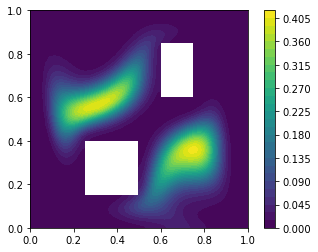

In [9]:
# user setting
t = 1

fom.plot(u=state, time=t)

## Measurements

In [10]:
# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = Detector(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

In [11]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.2]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time: ", time.time()-tStart, "s.")

measurement time:  0.015606164932250977 s.


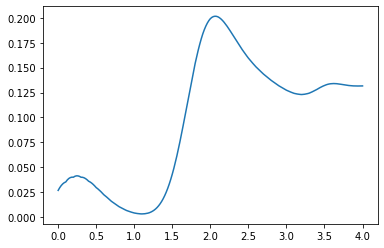

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(flight.grid_t, data)

Interpreting the data visually is a little bit harder for the transient setting than in the stationary setting, because, well, the state changes in time (duh) so we can't just plot a stationary figure in the background for comparison. Instead, for nice visualization, the block below creates a `.gif` that can be watched outside the notebook. Depending on the model setup this process can take a while, so the user has the opportunity to toggle this block using `bool_film_a_movie`.

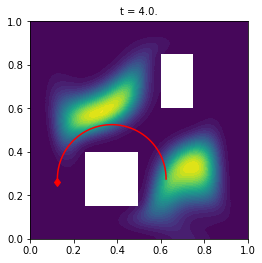

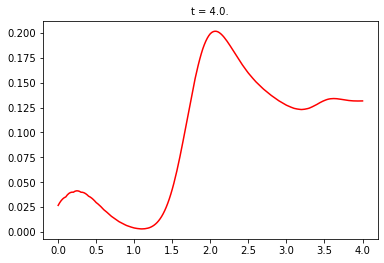

In [13]:
if bool_film_a_movie or True:
    film_a_movie.film_the_state(state=state, 
                                filename="plots/transientPDE_2", 
                                flight = flight, 
                                runtime=3, 
                                dt_disp=0.1)
    
    film_a_movie.film_the_data(data=data, 
                               filename="plots/transientData_2", 
                               grid_t = flight.grid_t, 
                               runtime=3, 
                               dt_disp=0.1)

To get these animations in shape for a conference talk, there's still some fine tuning to do. In general though, we see this works quite nicely and is much more fun to look at too.

## Getting ready for the OED problem

For the transient model, everything should work just as before. We follow the exact same steps as in the previous notebooks:

In [14]:
# define inverse problem
inversion = InverseProblem(fom, drone)

# compute the states for the parameter basis
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

# initialize object for computing the utility
utility = OEDUtility(inversion)

State solve time (2 parameters): 63.97824287414551 s


In [15]:
# user setting: control parameter
alpha = np.array([0.25, 0.2])

# compute posterior
tStart = time.time()
posterior = inversion.compute_posterior(alpha=alpha)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D-log"))
print("E-OED: ", utility.eval_utility(posterior, mode="E"))

print("Computation time for posterior and utility functions:", time.time()-tStart, "s.")

A-OED: 0.5603147824168399
D-OED: -4.628483718035741
E-OED:  0.5422997238480861
Computation time for posterior and utility functions: 0.029191970825195312 s.


## 2D visualization

We visualize the OED utility functions in 2D. We are again using radius and speed for reference because they are easy to interpret intuitively.

In [16]:
# admissible domain
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
# drone may not collide with buildings or leave the domain

final_time = drone.grid_t[-1]
speed_max = 2 * np.pi * radius_min / final_time
# maximum speed is chosen such that go for at most one circle

vec_speed = np.linspace(0.05 * speed_max, speed_max, n_test)
vec_radius = np.linspace(radius_min, radius_max, n_test+1)
# note: I'm not making the vectors the same lengths so I don't accidentally confuse the directions

In [17]:
if not bool_skip_2D_plots:

    tStart = time.time()

    # grid over admissible domain
    vec_speed_2d = np.linspace(0.05 * speed_max, speed_max, n_test_2d)
    vec_radius_2d = np.linspace(radius_min, radius_max, n_test_2d+1)

    # initialize
    util = np.zeros((3, n_test_2d+1, n_test_2d))

    for i in range(n_test_2d+1):
        
        print(f"iteration {i+1}/{n_test_2d+1}")
        
        for j in range(n_test_2d):

            alpha = np.array([vec_radius_2d[i], vec_speed_2d[j]])
            posterior = inversion.compute_posterior(alpha=alpha)

            util[0, i, j] = utility.eval_utility(posterior, mode="A")
            util[1, i, j] = utility.eval_utility(posterior, mode="D-log")
            util[2, i, j] = utility.eval_utility(posterior, mode="E")

    print("Runtime of this block: ", (time.time()-tStart)/60, "min.") 
    # expect 0.6 min for n_test_2d=10

iteration 1/21
iteration 2/21
iteration 3/21
iteration 4/21
iteration 5/21
iteration 6/21
iteration 7/21
iteration 8/21
iteration 9/21
iteration 10/21
iteration 11/21
iteration 12/21
iteration 13/21
iteration 14/21
iteration 15/21
iteration 16/21
iteration 17/21
iteration 18/21
iteration 19/21
iteration 20/21
iteration 21/21
Runtime of this block:  0.15479183594385784 min.


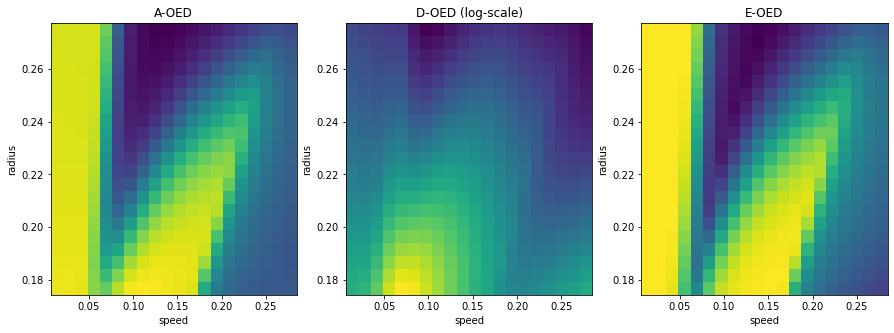

In [18]:
if not bool_skip_2D_plots:

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    for i in range(3):
        axs[i].pcolormesh(vec_speed_2d, vec_radius_2d, util[i, :, :])
        axs[i].set_xlabel("speed")
        axs[i].set_ylabel("radius")

    axs[0].set_title("A-OED")
    axs[1].set_title("D-OED (log-scale)")
    axs[2].set_title("E-OED")

This time, we actually see a big difference between the different utility functions. We explain this in the next section below.

In [19]:
# user input: Where to evaluate the derivative:
speed_test = 0.075 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.25 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref = inversion.compute_posterior(alpha=alpha_test)

util_ref = np.zeros(4)
print("Evaluating utility at reference")
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D-log")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

print("Evaluating derivatives at reference")
tStart_sub = time.time()
der_ref_A = utility.d_utility_d_control(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_control(posterior_ref, mode="D-log")
der_ref_Dinv = utility.d_utility_d_control(posterior_ref, mode="D-inverse")
print("mean time for taking derivatives: ", (time.time()-tStart_sub)/3, " s.")
## done with the important part

print("Starting to compute 1D plot points")
util_test = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    print("iteration {} / {}".format(i+1, n_test+1))
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha=alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D-log")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha=alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D-log")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.") 

Evaluating utility at reference
Evaluating derivatives at reference
mean time for taking derivatives:  37.05340234438578  s.
Starting to compute 1D plot points
iteration 1 / 41
iteration 2 / 41
iteration 3 / 41
iteration 4 / 41
iteration 5 / 41
iteration 6 / 41
iteration 7 / 41
iteration 8 / 41
iteration 9 / 41
iteration 10 / 41
iteration 11 / 41
iteration 12 / 41
iteration 13 / 41
iteration 14 / 41
iteration 15 / 41
iteration 16 / 41
iteration 17 / 41
iteration 18 / 41
iteration 19 / 41
iteration 20 / 41
iteration 21 / 41
iteration 22 / 41
iteration 23 / 41
iteration 24 / 41
iteration 25 / 41
iteration 26 / 41
iteration 27 / 41
iteration 28 / 41
iteration 29 / 41
iteration 30 / 41
iteration 31 / 41
iteration 32 / 41
iteration 33 / 41
iteration 34 / 41
iteration 35 / 41
iteration 36 / 41
iteration 37 / 41
iteration 38 / 41
iteration 39 / 41
iteration 40 / 41
iteration 41 / 41
Runtime of this block:  1.885799531141917 min.


Text(0.5, 0, 'speed')

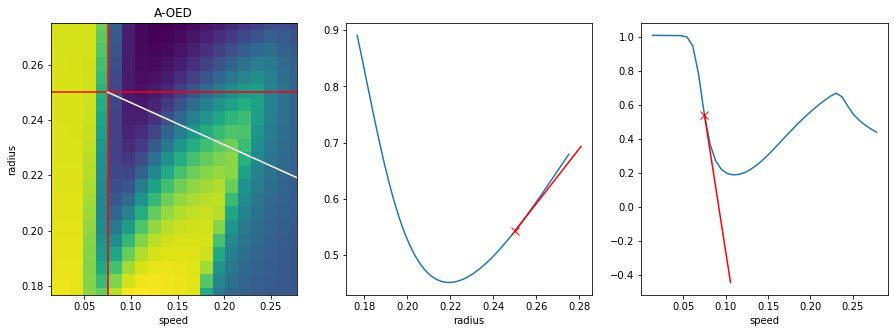

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_A)
scale = 1/norm

if not bool_skip_2D_plots:
    axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[0, :, :])
    axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
    axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
    axs[0].plot([speed_test, speed_test - scale * der_ref_A[1]], 
                [radius_test, radius_test - scale * der_ref_A[0]], 
                color = "w", marker = None)
    axs[0].set_xlabel("speed")
    axs[0].set_ylabel("radius")
    axs[0].set_xlim([np.min(vec_speed), np.max(vec_speed)])
    axs[0].set_ylim([np.min(vec_radius), np.max(vec_radius)])
    axs[0].set_title("A-OED")

axs[1].plot(vec_radius, util_test[0, 1, :])
axs[1].plot([radius_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[0, 0, :-1])
axs[2].plot([speed_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Text(0.5, 0, 'speed')

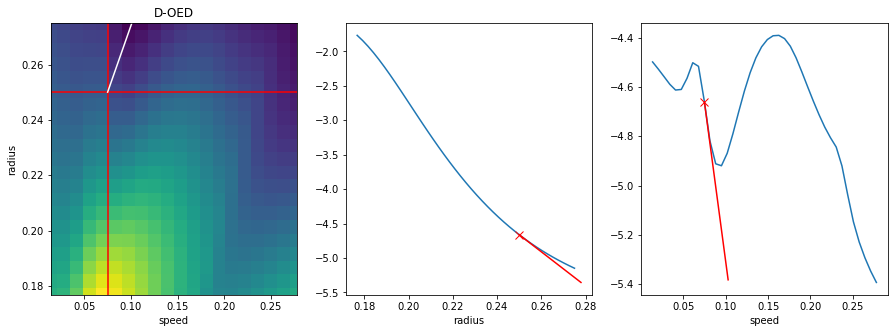

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_D)
scale = 1/norm

if not bool_skip_2D_plots:
    axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[1, :, :])
    axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
    axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
    axs[0].plot([speed_test, speed_test - scale * der_ref_D[1]], 
                [radius_test, radius_test - scale * der_ref_D[0]], 
                color = "w", marker = None)
    axs[0].set_xlabel("speed")
    axs[0].set_ylabel("radius")
    axs[0].set_xlim([np.min(vec_speed), np.max(vec_speed)])
    axs[0].set_ylim([np.min(vec_radius), np.max(vec_radius)])
    axs[0].set_title("D-OED")

axs[1].plot(vec_radius, util_test[1, 1, :])
axs[1].plot([radius_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[1, 0, :-1])
axs[2].plot([speed_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

## Interpreting the utility functions
Let's understand why, in constrast to the stationary model, the OED utility functions look so different.

**Note:** For easiest interpretability, use two parameters only, one fairly close to the starting point of the drone, one further away. The text below is based on `centers = [[0.35, 0.7], [0.8, 0.2]]`.

We'll need to distinguish between the measurements taken of the different parameters.

In [22]:
para1 = np.array([1, 0])
para2 = np.array([0, 1])

tStart = time.time()
state1 = fom.solve(parameter=para1)
print("FOM solve time: {} s.".format(time.time()-tStart))

tStart = time.time()
state2 = fom.solve(parameter=para2)
print("FOM solve time: {} s.".format(time.time()-tStart))

FOM solve time: 31.82221794128418 s.
FOM solve time: 31.449991941452026 s.


to start, we set the speed to be very low: `speed_test = 0.025`.

In [23]:
speed_test = 0.025 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.18 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref2 = inversion.compute_posterior(alpha=alpha_test)

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha_test)

# measure data
data11 = drone.measure(flight=flight, state=state1)
data21 = drone.measure(flight=flight, state=state2)

if bool_film_a_movie:
    film_a_movie.film_the_state(state=state1, 
                            filename="plots/transientPDE_flight1_1", 
                            flight = flight, 
                            runtime=3, 
                            dt_disp=0.1)

    film_a_movie.film_the_data(data=data11, 
                               filename="plots/transientData_flight1_1", 
                               grid_t = flight.grid_t, 
                               runtime=3, 
                               dt_disp=0.1)

    film_a_movie.film_the_state(state=state2, 
                                filename="plots/transientPDE_flight1_2", 
                                flight = flight, 
                                runtime=3, 
                                dt_disp=0.1)

    film_a_movie.film_the_data(data=data21, 
                               filename="plots/transientData_flight1_2", 
                               grid_t = flight.grid_t, 
                               runtime=3, 
                               dt_disp=0.1)

util_ref2 = np.zeros(4)
print("Evaluating utility at reference")
util_ref2[0] = utility.eval_utility(posterior_ref2, mode="A")
util_ref2[1] = utility.eval_utility(posterior_ref2, mode="D-log")
util_ref2[2] = utility.eval_utility(posterior_ref2, mode="D-inverse")
util_ref2[3] = utility.eval_utility(posterior_ref2, mode="E")

print("Evaluating derivatives at reference")
tStart_sub = time.time()
der_ref_A2 = utility.d_utility_d_control(posterior_ref2, mode="A")
der_ref_D2 = utility.d_utility_d_control(posterior_ref2, mode="D-log")
der_ref_Dinv2 = utility.d_utility_d_control(posterior_ref2, mode="D-inverse")
print("mean time for taking derivatives: ", (time.time()-tStart_sub)/3, " s.")
## done with the important part

print("Starting to compute 1D plot points")
util_test2 = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    #print("iteration {} / {}".format(i+1, n_test+1))
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha=alpha)

        util_test2[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test2[1, 0, i] = utility.eval_utility(posterior, mode="D-log")
        util_test2[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test2[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha=alpha)

    util_test2[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test2[1, 1, i] = utility.eval_utility(posterior, mode="D-log")
    util_test2[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test2[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.") 

Evaluating utility at reference
Evaluating derivatives at reference
mean time for taking derivatives:  0.01382120450337728  s.
Starting to compute 1D plot points
Runtime of this block:  0.028984566529591877 min.


With respect to the speed, the utility function for `speed_test = 0.025`, `radius_test = 0.18` is approximately at a local minimum for D-OED, and at a local maximum for A-OED.

Text(0.5, 1.0, 'D-OED')

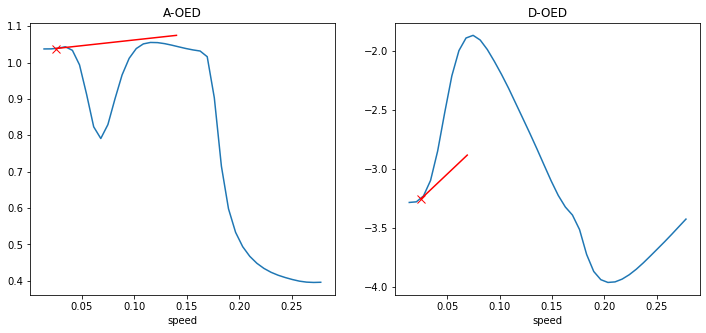

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

norm = la.norm(der_ref_A2)
scale = 0.1/norm

axs[0].plot(vec_speed, util_test2[0, 0, :-1])
axs[0].plot([speed_test], util_ref2[0], marker="x", markersize=8, color="r")
axs[0].plot([speed_test, speed_test + scale], 
            [util_ref2[0], util_ref2[0]+scale*der_ref_A2[1]], 
            marker="", markersize=8, color="r")
axs[0].set_xlabel("speed")
axs[0].set_title("A-OED")

norm = la.norm(der_ref_D2)
scale = 1/norm

axs[1].plot(vec_speed, util_test2[1, 0, :-1])
axs[1].plot([speed_test], util_ref2[1], marker="x", markersize=8, color="r")
axs[1].plot([speed_test, speed_test + scale], 
            [util_ref2[1], util_ref2[1]+scale*der_ref_D2[1]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("speed")
axs[1].set_title("D-OED")



This is explained by how much information the drone measures of each parameter.

A-OED: 1.0385643239331164
D-OED: -3.2549068616668175
E-OED: 0.9999791034511225

Posterior covariance matrix: 
 [[ 9.99978982e-01 -3.42009104e-04]
 [-3.42009104e-04  3.85853421e-02]]


(0.0, 0.12)

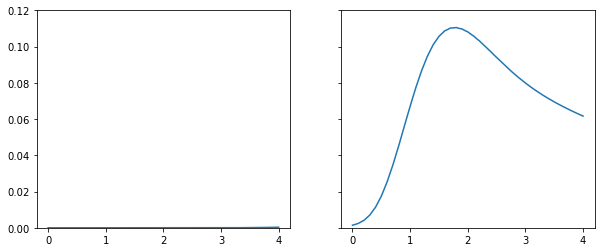

In [25]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_test)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D-log"))
print("E-OED:", utility.eval_utility(posterior, mode="E"))

print("\nPosterior covariance matrix: \n", posterior.compute_covariance())

fig, axs = plt.subplots(1,2, figsize=(10, 4), sharey = True)
axs[0].plot(flight.grid_t, data11)
axs[1].plot(flight.grid_t, data21)

axs[0].set_ylim((0, 0.12))

The speed is so slow, the drone only picks up information about the second parameter. It does not travel far enough to measure any state change contributed by the first parameter. Consequently, the posterior uncertainty only improves for the second parameter, and stays approximately equal for the first (see print of posterior covariance matrix). On the other hand, the slow speed allows the drone to really capture a lot of detail about the second parameter, so the uncertainty for the second actually improves a lot (variance goes down from 1 to 0.039).

D-OED measures the volume of the uncertainty ellipsoid (product of posterior eigenvalues). It is already happy when one eigenvalue decreases. The uncertainty ellipsoid might be long and skinny, but D-OED is perfectly fine with that.

A-OED, in contrast, measures the mean axis length of the uncertainty ellipsoid. It is much less impressed when only one eigenvalue is decreased. For two parameters, even bringing the uncertainty in one parameter to zero would only half the A-OED utility function (while D-OED would be zero). For more parameters, the effect would be even smaller. Instead, A-OED prefers if the uncertainty in the parameters is decreased more evenly.

Evaluating utility at reference
A-OED: 0.7928701704470293
D-OED: -1.8810014608101921
E-OED: 0.46516213635802844

Posterior covariance matrix: 
 [[ 9.99978982e-01 -3.42009104e-04]
 [-3.42009104e-04  3.85853421e-02]]


(0.0, 0.12)

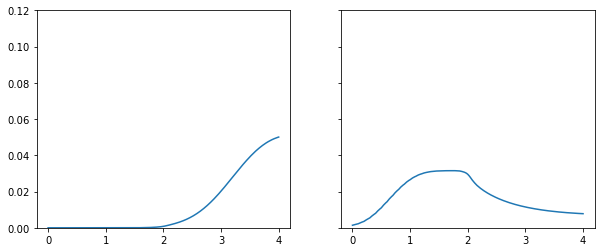

In [26]:
speed_test2 = 0.069 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.18 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275
alpha_test2 = np.array([radius_test, speed_test2])

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha_test2)

# measure data
data12 = drone.measure(flight=flight, state=state1)
data22 = drone.measure(flight=flight, state=state2)

if bool_film_a_movie:
    film_a_movie.film_the_state(state=state1, 
                            filename="plots/transientPDE_flight2_1", 
                            flight = flight, 
                            runtime=3, 
                            dt_disp=0.1)

    film_a_movie.film_the_data(data=data12, 
                               filename="plots/transientData_flight2_1", 
                               grid_t = flight.grid_t, 
                               runtime=3, 
                               dt_disp=0.1)

    film_a_movie.film_the_state(state=state2, 
                                filename="plots/transientPDE_flight2_2", 
                                flight = flight, 
                                runtime=3, 
                                dt_disp=0.1)

    film_a_movie.film_the_data(data=data22, 
                               filename="plots/transientData_flight2_2", 
                               grid_t = flight.grid_t, 
                               runtime=3, 
                               dt_disp=0.1)

# compute posterior
posterior3 = inversion.compute_posterior(alpha=alpha_test2)

util_ref3 = np.zeros(4)
print("Evaluating utility at reference")
util_ref3[0] = utility.eval_utility(posterior3, mode="A")
util_ref3[1] = utility.eval_utility(posterior3, mode="D-log")
util_ref3[2] = utility.eval_utility(posterior3, mode="D-inverse")
util_ref3[3] = utility.eval_utility(posterior3, mode="E")

print("A-OED:", util_ref3[0])
print("D-OED:", util_ref3[1])
print("E-OED:", util_ref3[3])

print("\nPosterior covariance matrix: \n", posterior.compute_covariance())

fig, axs = plt.subplots(1,2, figsize=(10, 4), sharey = True)
axs[0].plot(flight.grid_t, data12)
axs[1].plot(flight.grid_t, data22)

axs[0].set_ylim((0, 0.12))

If we instead consider the speed `speed_test = 0.069`, then the uncertainty in each parameter is improved approximately evenly. Looking at the measurements for each parameter (plot above), we also see that we are measureing information about each.

Text(0.5, 1.0, 'D-OED')

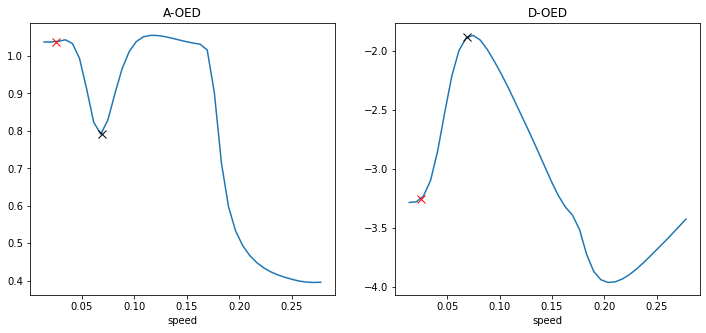

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(vec_speed, util_test2[0, 0, :-1])
axs[0].plot([speed_test], util_ref2[0], marker="x", markersize=8, color="r")
axs[0].plot([speed_test2], util_ref3[0], marker="x", markersize=8, color="k")
axs[0].set_xlabel("speed")
axs[0].set_title("A-OED")

axs[1].plot(vec_speed, util_test2[1, 0, :-1])
axs[1].plot([speed_test], util_ref2[1], marker="x", markersize=8, color="r")
axs[1].plot([speed_test2], util_ref3[1], marker="x", markersize=8, color="k")
axs[1].set_xlabel("speed")
axs[1].set_title("D-OED")

We see that for `speed_test = 0.069`, A-OED is at a local minimum, D-OED is at a local maximum. It is not always the case that A- and D-OED are complimentary in this sense. If we look at the 2D plots above, their behavior is actually very similar for the majority of radius-speed combinations. We have here just looked at some of the extreme cases.

## The End.

In [28]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 4.9773120999336244 min
